# Web scraping and data visualization: Roller  derby stats.  

As a roller derby player myself, it was only natural for me to look for roller derby statistics when trying to decide on a web scraping project.  Stats are scraped from flattrackstats.com.  First I will set scrape the site for multiple teams then do a closer examination of the stats for a particular team.

In [1]:
#import libraries and set some preferences
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.width=None
import warnings
warnings.filterwarnings('ignore')

## Scraping the site

Flattrackstats has their statistics separated by team number.  Each team page contains data table with bout statistics for many years.  Each of these tables spans an additional four pages.  I will two functions to perform the data scraping.  The teamurl function takes in a particle team number and returns the url for that particular team's page.  The derby scrape function loops through each team number and each team's pages.  It uses pandas read_html method to scrape the pages and BeautifulSoup to parse them for team specific information.  The raw data contains columns for home team names and visitor team names.  In order to more easily analyze data by team, I would rather have columns that list the team name, the opponent, and whether the bout is home or away.  To do that, I use BeautifulSoup to extract the team name for each team number and store those names in a new column. 

In [2]:
#function to get team specific url
def teamurl (team_no):
    base_site='http://flattrackstats.com/teams/'+str(team_no)
    return base_site


In [3]:
#function to scrape flattrack stats for particular teams, takes int. for number of pages for each team and a list of team numbers
def derby_scrape (pages,team_nums):
    
#set up a datafframe for tables from each url and team names
    tabs=pd.DataFrame()
    name=pd.DataFrame()


#loop through all desired team numbers
    for t in team_nums:
        baseurl=teamurl(t)
        
#loop through each page the table spans 
        for p in range(pages):
            url=baseurl+'?page={0}'.format(p) 
            df=pd.read_html(url)
            
#get data from statistics table (5th table on page), use BeautifulSoup to get the name for each team's number.
            st=df[5]
            response=requests.get(url)
            html=response.content
            soup=BeautifulSoup(html, 'lxml')
            st['Team']=soup.find('div', {'class':'leaguename'}).text
            tabs=tabs.append(st)   
    return tabs

In [4]:
#scrape the site, for this site each team has 5 pages of data so input 4 and a list of team numbers 
rd_df=derby_scrape(4,list(range(3397,3402)))

In [5]:
rd_df.head()

,Date,Sanc.,Home Team,Score,Visitor Team,Score.1,Score Diff,Tournament,Bout Stats,Team
0,8/17/19,NaN,Big Easy,184.0,Bux-Mont,59.0,125.0,NaN,Stats,Big Easy Rollergirls
1,7/27/19,NaN,Big Easy,283.0,Carolina,55.0,228.0,NaN,Stats,Big Easy Rollergirls
2,6/22/19,NaN,Big Easy,156.0,Rockin' City,82.0,74.0,NaN,Stats,Big Easy Rollergirls
3,6/22/19,NaN,North Texas,98.0,Big Easy,132.0,34.0,NaN,Stats,Big Easy Rollergirls
4,6/15/19,NaN,Big Easy,123.0,Nashville,160.0,-37.0,NaN,Stats,Big Easy Rollergirls


## Data Cleaning

In [6]:
rd_df.reset_index(inplace=True, drop=True)

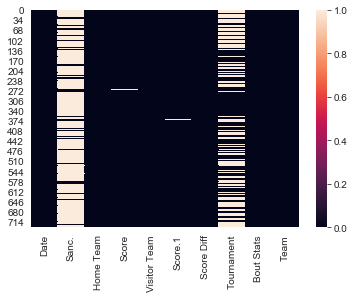

In [7]:
#use seaborn heatmap to see where values are missing.  
sns.heatmap(rd_df.isnull())

In [8]:
#very few rows have data for sanc. column so I will drop that column. 
#score diff is dropped since it provides no new info
#Bout stats column is dropped since it is just a series of links to mostly empty stat pages
rd_df.drop(['Sanc.', 'Score Diff', 'Bout Stats'], axis=1, inplace=True)

I need to create a column that denotes whether a particular bout was home or away.  To do that, I use a loop over all the bouts and compare the first word of the Team column with the first of the Home Team column.  We cannot simply compare the two columns because the Team column gives the full team name while the Home Team column uses shortened versions.

In [9]:
#set up a list to store values denoting whether a bout was at home or away 
home=[]
for i in range(rd_df.shape[0]):
    tName=rd_df['Team'][i].split()
    hTeam=rd_df['Home Team'][i].split()
    if tName[0]==hTeam[0]:
        home.append('yes')
    else:
        home.append('no')
rd_df['HomeBout']=home

In [10]:
#for each home bout fill the opponent column with the visitor team, and for each away bout fill opponent with home team.  
#same for team's score and opponent's score
Tscore=[]
Oscore=[]
Opponent=[]
for i in range(rd_df.shape[0]):
    if rd_df['HomeBout'][i]=='yes':
        Opponent.append(rd_df['Visitor Team'][i])
        Tscore.append(rd_df['Score'][i])
        Oscore.append(rd_df['Score.1'][i])
    else:
        Opponent.append(rd_df['Home Team'][i])
        Tscore.append(rd_df['Score.1'][i])
        Oscore.append(rd_df['Score'][i])
rd_df['Opponent']=Opponent
rd_df['Team_score']=Tscore
rd_df['Opponent_score']=Oscore

Next I will tackle the tournament column.  The name of a particular tournament is not particularly useful but we may want to know whether a bout was part of a tournament or not.  Tournaments generally involve multiple bouts played over at most a few days as opposed to non-tournament bouts that may take place only once a month.  All of the null values can be replaced with 'no' and the tournament names can be replaced with 'yes.'

In [11]:
rd_df['Tournament'].fillna('no', inplace=True)
rd_df['Tournament']=np.where(rd_df['Tournament']!='no', 'yes', 'no')

In [12]:
#checkpoint
df2=rd_df.copy()
df2.head()

,Date,Home Team,Score,Visitor Team,Score.1,Tournament,Team,HomeBout,Opponent,Team_score,Opponent_score
0,8/17/19,Big Easy,184.0,Bux-Mont,59.0,no,Big Easy Rollergirls,yes,Bux-Mont,184.0,59.0
1,7/27/19,Big Easy,283.0,Carolina,55.0,no,Big Easy Rollergirls,yes,Carolina,283.0,55.0
2,6/22/19,Big Easy,156.0,Rockin' City,82.0,no,Big Easy Rollergirls,yes,Rockin' City,156.0,82.0
3,6/22/19,North Texas,98.0,Big Easy,132.0,no,Big Easy Rollergirls,no,North Texas,132.0,98.0
4,6/15/19,Big Easy,123.0,Nashville,160.0,no,Big Easy Rollergirls,yes,Nashville,123.0,160.0


I'd like to be able to look at yearly or monthly stats so I format the date column and extra the year and month to their own columns.  

In [13]:
df2['Date']=pd.to_datetime(df2['Date'])
df2['month'] = pd.DatetimeIndex(df2['Date']).month
df2['year']=pd.DatetimeIndex(df2['Date']).year
df2['win']=np.where(df2['Score']>df2['Score.1'], 'win','loss')

   Now there are quite a few columns that are no longer needed so I'll drop them and reorder my columns. 

In [14]:
df2.drop(['Home Team', 'Score', 'Visitor Team', 'Score.1'], axis=1, inplace=True)


In [15]:
df2.columns

Index(['Date', 'Tournament', 'Team', 'HomeBout', 'Opponent', 'Team_score',
       'Opponent_score', 'month', 'year', 'win'],
      dtype='object')

In [16]:
col_names=['Team', 'Opponent','Date', 'Team_score', 'Opponent_score','win', 'HomeBout', 'Tournament', 'month','year']
df2=df2[col_names]

In [113]:
df2.head()

,Team,Opponent,Date,Team_score,Opponent_score,win,HomeBout,Tournament,month,year
0,Big Easy Rollergirls,Bux-Mont,2019-08-17,184.0,59.0,win,yes,no,8,2019
1,Big Easy Rollergirls,Carolina,2019-07-27,283.0,55.0,win,yes,no,7,2019
2,Big Easy Rollergirls,Rockin' City,2019-06-22,156.0,82.0,win,yes,no,6,2019
3,Big Easy Rollergirls,North Texas,2019-06-22,132.0,98.0,loss,no,no,6,2019
4,Big Easy Rollergirls,Nashville,2019-06-15,123.0,160.0,loss,yes,no,6,2019


## Calculations and Visualizations

I'd like to examine some stats for a particular team in more detail.  For the sake of example, I'll use my team, Big Easy Rollergirls.

In [18]:
#checkpoint
df=df2.copy()

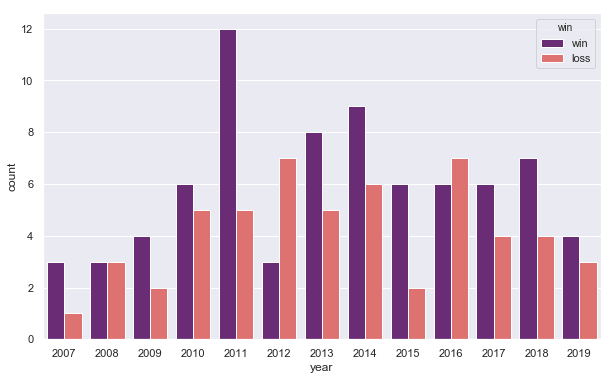

In [19]:
sns.set(rc={'figure.figsize':(10,6)})           
sns.countplot('year', data=df[df['Team']=='Big Easy Rollergirls'], hue='win', palette='magma')
plt.show()

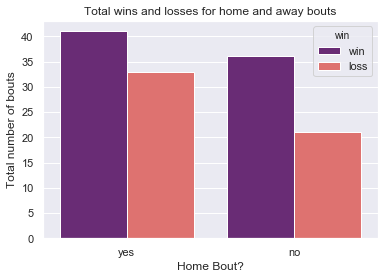

In [47]:
sns.set(rc={'figure.figsize':(6,4)})
sns.countplot(x='HomeBout', data=df[df['Team']=='Big Easy Rollergirls'], hue='win', palette='magma')
plt.title('Total wins and losses for home and away bouts')
plt.xlabel('Home Bout?')
plt.ylabel('Total number of bouts')
plt.show()

In [21]:
#function to calculate win ratio.  takes a dataframe and team name
def win_rat (df, team):
    tdf=df[df['Team']==team]
    tot_bouts=tdf.groupby(['year'])['win'].size()
    tot_wins=tdf[tdf['win']=='win'].groupby(['year'])['win'].size()
    win_ratio=tot_wins/tot_bouts
    return win_ratio

In [22]:
#function to calculate points per bout
def ppb (df, team):
    tdf=df[df['Team']==team]
    tot_bouts=tdf.groupby(['year'])['win'].size()
    tot_points=tdf.groupby('year')['Team_score'].sum()
    ppb=tot_points/tot_bouts
    return ppb

In [33]:
wr_be=win_rat(df,'Big Easy Rollergirls')
ppb_be=ppb(df, 'Big Easy Rollergirls')

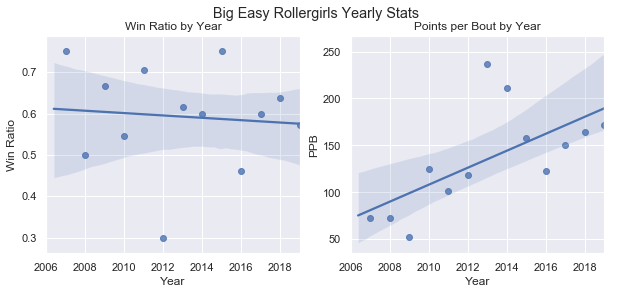

In [34]:
#plot team specific win ratio and ppb
fig, axes = plt.subplots(1, 2, figsize=(10,4))
years=list(range(2007,2020))
ax1=sns.regplot(y=wr_be, x=years, ax=axes[0], color='b')
ax2=sns.regplot(y=ppb_be, x=years, ax=axes[1], color='b')
ax1.set_xlim(2006,2019)
ax2.set_xlim(2006,2019)
ax1.set_title('Win Ratio by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Win Ratio')
ax2.set_title('Points per Bout by Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('PPB')
plt.suptitle('Big Easy Rollergirls Yearly Stats')
plt.show()



Sadly, it would seem that our win ratio is decreasing slightly over time.  Before we get too disappointed, I'll point out that their is a very large variance and the decrease since 2007 is small as can be seen in the slope of the trend line.  It is more encouraging to see that our points per bout has been steadily increasing over time.

In [53]:
#function to find win ratio for entire time period
def wr_all (df, team):
    tdf=df[df['Team']==team]
    tot_bouts=tdf['win'].shape[0]
    tot_wins=tdf[tdf['win']=='win']['win'].shape[0]
    win_ratio=tot_wins/tot_bouts
    return win_ratio

In [84]:
#get wr_all for all teams
wr=[]
for t in df['Team'].unique(): 
    wr.append(wr_all(df, t))

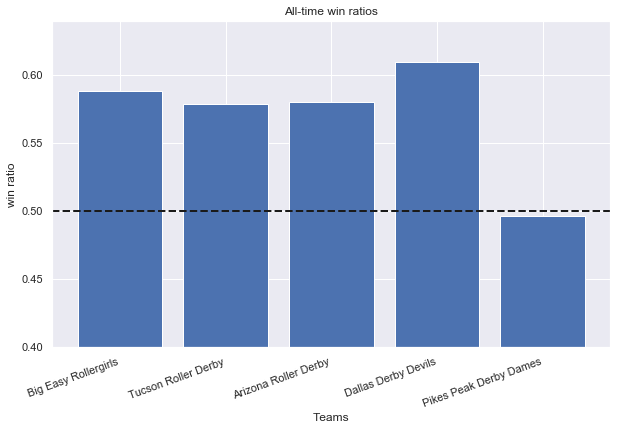

In [112]:
plt.figure(figsize=(10,6))
plt.bar(x=df['Team'].unique(), height=wr)
plt.xticks(rotation=20, ha='right')
plt.ylim(bottom=.4)
plt.axhline(y=0.5,linewidth=2, linestyle='--',color='k')
plt.title('All-time win ratios')
plt.xlabel('Teams')
plt.ylabel('win ratio')
plt.show()

This final plot shows the win ratio for each of the teams over the entire time period.  The ratios above the dashed lines represent winning records (ie won at least 50% of their bouts).  Of these five teams, the Dallas Derby Dolls have the best ll time win ratio.